# Collaboration and Competition : Report.

---

#### imports

In [2]:
import os
from IPython.display import Image
import matplotlib.pyplot as plt

from marl_coop.utils import (load_scores, Runner, plot_scores)
from marl_coop.utils.loader import load_MADDPG_agent

path_images = r'../image'

## Learning algorithm : Multi-Agent Deep Deterministic Policy Gradient (MADDPG)

Despite the all the success of single agent learning (Atari Games[], ), the most usefull applications of AI ,such as having interacted agents, are still limited by the **great challenges of multi-agent learning(MAL)**.

The biggest flaw of MAL must be the **non-sationarity of the environment** from the point of view of every single agent. Indeed, since all agents are taking actions, the state transition function no longer depend only on the agent actions but also one policy of all other agents i.e $P(s'|s,a,\pi_{1 \dots n})$ won't be constant if any $\pi_i$ has been updated.

**MADDPG** adress the non-stationarity of the environment by introducing an architecture that mix **a centralized training and a decentralized execution**. Because the actions of all the agents are taken into account, the environment become stationary and thus a replay buffer can be used. The *figure 1* show the MADDPG architecture (reférence : [MADDPG original paper](https://arxiv.org/pdf/1706.02275.pdf)).

It adapts naturally to an actor-critic architecture where at training the critic is augmented with additional information about the policies of other agents and at test time, only the actor is used, operating on local information only. It is an adaptation of DDPG and thus relies on a **deterministic policy**.

**DDPG** is a **model-free**, **off-policy** **actor-critic** algorithm using deep function approximators that can learn policies in high-dimensional, continuous action spaces.

Figure 1 : Overview of the multi-agent decentralized actor, centralized critic approach. 



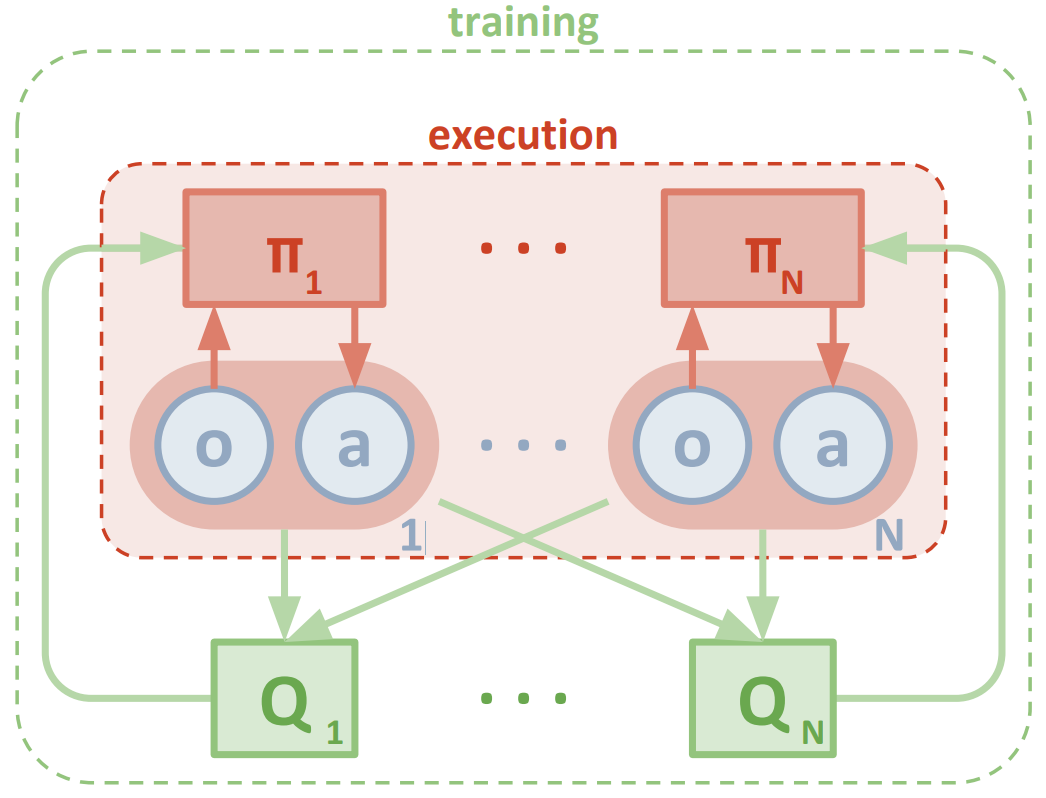

In [4]:
print('Figure 1 : Overview of the multi-agent decentralized actor, centralized critic approach. \n')
Image(os.path.join(path_images, 'MADDPG_architechture.png'), width = 600, height = 400) 

### Choosen hyperparameters

- **gamma** ($\gamma$) : $0.98$ a slightly low discount factor that trades more stability for a little bias.


- **actor learning rate** ($\alpha_{actor} $): $8\times10^{-5}$ a slightly diminished value for the actor learning rate.


- **critic learning rate** ($\alpha_{critic} $) : $3 \times 10^{-4}$ a low value (one third of what is usually used). This was needed to stabilize the learning.


- **tau**  ($\tau$ ): $1 \times 10^{-3}$ the soft update of the target network parameter. It is the original value from the experiment details of [Continuous control with deep reinforcement learning](https://arxiv.org/abs/1509.02971).


- **batch size** : $512$ the number of experinces used at each learning.This value is high compared at was is done in the field. The idea behind this choice is to lower the variance of the update of the actor since the mean of the Q_values over all the batch is used.


- **update rate** :every $20$ steps thethe learning step will occur. This parameter was also introduced to stabilize learning.


- **buffer type** : *Prioritized Experience Replay* using a *Sumtree* to store the experiences. PER unable slightly faster learning and to maintain a higher level of performance once the environment is solved. Because the chosen batch size is large, the sumtree was needed to fasten the prioritized sampling. The performance could be even more increased by adding parallelism in its implementation


- **buffer size** : $10^{5}$, once the PER was implemented, the size of the buffer was increased to the classic value.


- **noise process** : *scaling Ornstein-Uhlenbeck process*. Even if it has been demonstrated that gaussian noise is as efficient, the  Ornstein-Uhlenbeck process of the original paper was prefered. It's natural inertia can lead to a more wide spread exploration.The scaling part transform an initial high value of amplitude ($\sigma = 1$) and low mean attraction ($\theta = 0.3$) into lower amplitude with less divergence from the mean ($\sigma = 0.01$ and $\theta = 0.1$) in a parametrized number (*100 000*) of actions. It correspond to $\approx$ *1000* episodes until the parameter reach half of their final values and $\approx$ *5000* episodes until their final values. Like and epsilon greedy policy, it speed up learning initialy by explorating a lot and then it allow to reach higher performances.


- **gradient clipping**: $0.8$ The critic network is updated with clipped gradient updates. This helps gradient descent to have a reasonable behaviour even if the loss landscape of the model is irregular. This stabilize the whole learning by also impacting the evaluation of the actor.

### Network model architecture

The **actor** network is composed of **two layers of size $64$ and $54$** for $5100$ parameters that map a inputed observation to an action. At each layer, a **batch normalization** is applied before the application of the **ReLU** activation functions. Finally a **tanh** activation function is applied on top of the output in order to constrain it to the domain of the action space $[-1,1]$. 

The **critic** network is composed of **two layers of size $64$ and $54$** for $6838$ parameters that map the concatenation of the observations of all agents and the action of all agents to the expected return of that set of observations/actions as a Q-value approximator. Similarly, at each layer, a **batch normalization** is applied before the application of the **ReLU** activation functions.

The final layer weights and biases of both the actor and critic were initialized from a uniform distribution $[-3 \times 10^{-3},3 \times 10^{-3} ]$. The other layers were initialized from uniform distributions $[-\frac{1}{\sqrt{f}},-\frac{1}{\sqrt{f}}]$ where f is the fan-in of the layer.

The critic use as criterion the **Smooth L1-loss** that combines the advantages of L1-loss (steady gradients for large inputs) and L2-loss (less oscillations during updates when the input is small).

There is a lot of room to improve the architecture of the networks. We can experiment on the cardinality of the layer, the initialization method and the activation function. For instance, it could be interesting to test the Leaky RelU activativation function or gaussian network.

### Plot of the reward

The best result was **XXXX** episodes to solve the environment as displayed below. The environment used contained 20 agents. This run correspond to the one shown in `Tennis_collaboration` in the section *Training the agents over 10 000 episodes*.

In [ ]:
score = load_scores(key='my_key')
plot_scores(score, window_size=100,target_score=.5)

### Development of the project

The first implementation of MADDPG with the original parameters show no sign of learning. Many experimentations had to took place in order to end up with a learning algorithm. As those tries were at least as interesting as the final result, the main ideas are presented below.  
When examining the next figures, it is important to keep in mind that the scaling of the graphics is different.

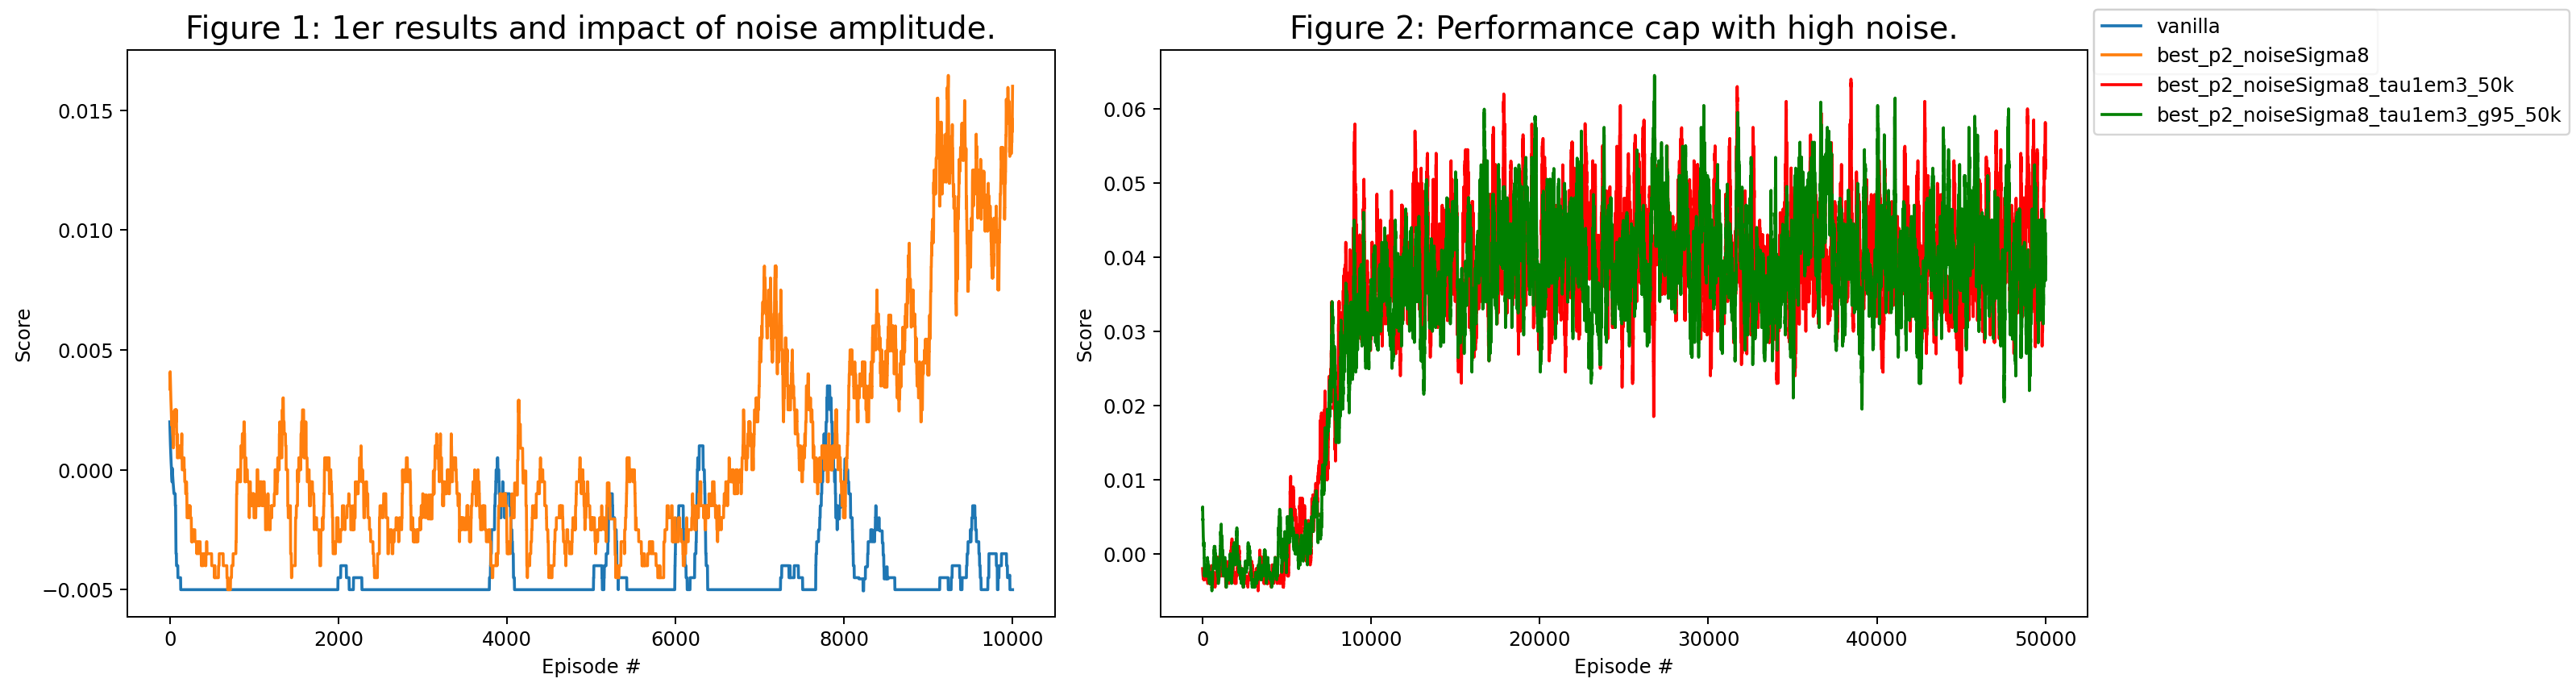

In [10]:
fig, axes = plt.subplots(1,2,figsize=(15,5), dpi=175)
axes = iter(axes.flatten())

plot_scores(load_scores(keys=['vanilla','best_p2_noiseSigma8']),
            window_size=100, axe=next(axes), title="Figure 1: 1er results and impact of noise amplitude.")
plot_scores(load_scores(keys=['best_p2_noiseSigma8_tau1em3_50k','best_p2_noiseSigma8_tau1em3_g95_50k']),
            window_size=100, axe=next(axes), colors=['r','g'], title="Figure 2: Performance cap with high noise.")

In *Figure 1* are compared the base version which was not learning at all with the first learning version whose noise amplitude was eight times the original one.  
Despite those promising initial performances, the performance capped around 0.4 after 10000 episode as shown in *Figure 2*.

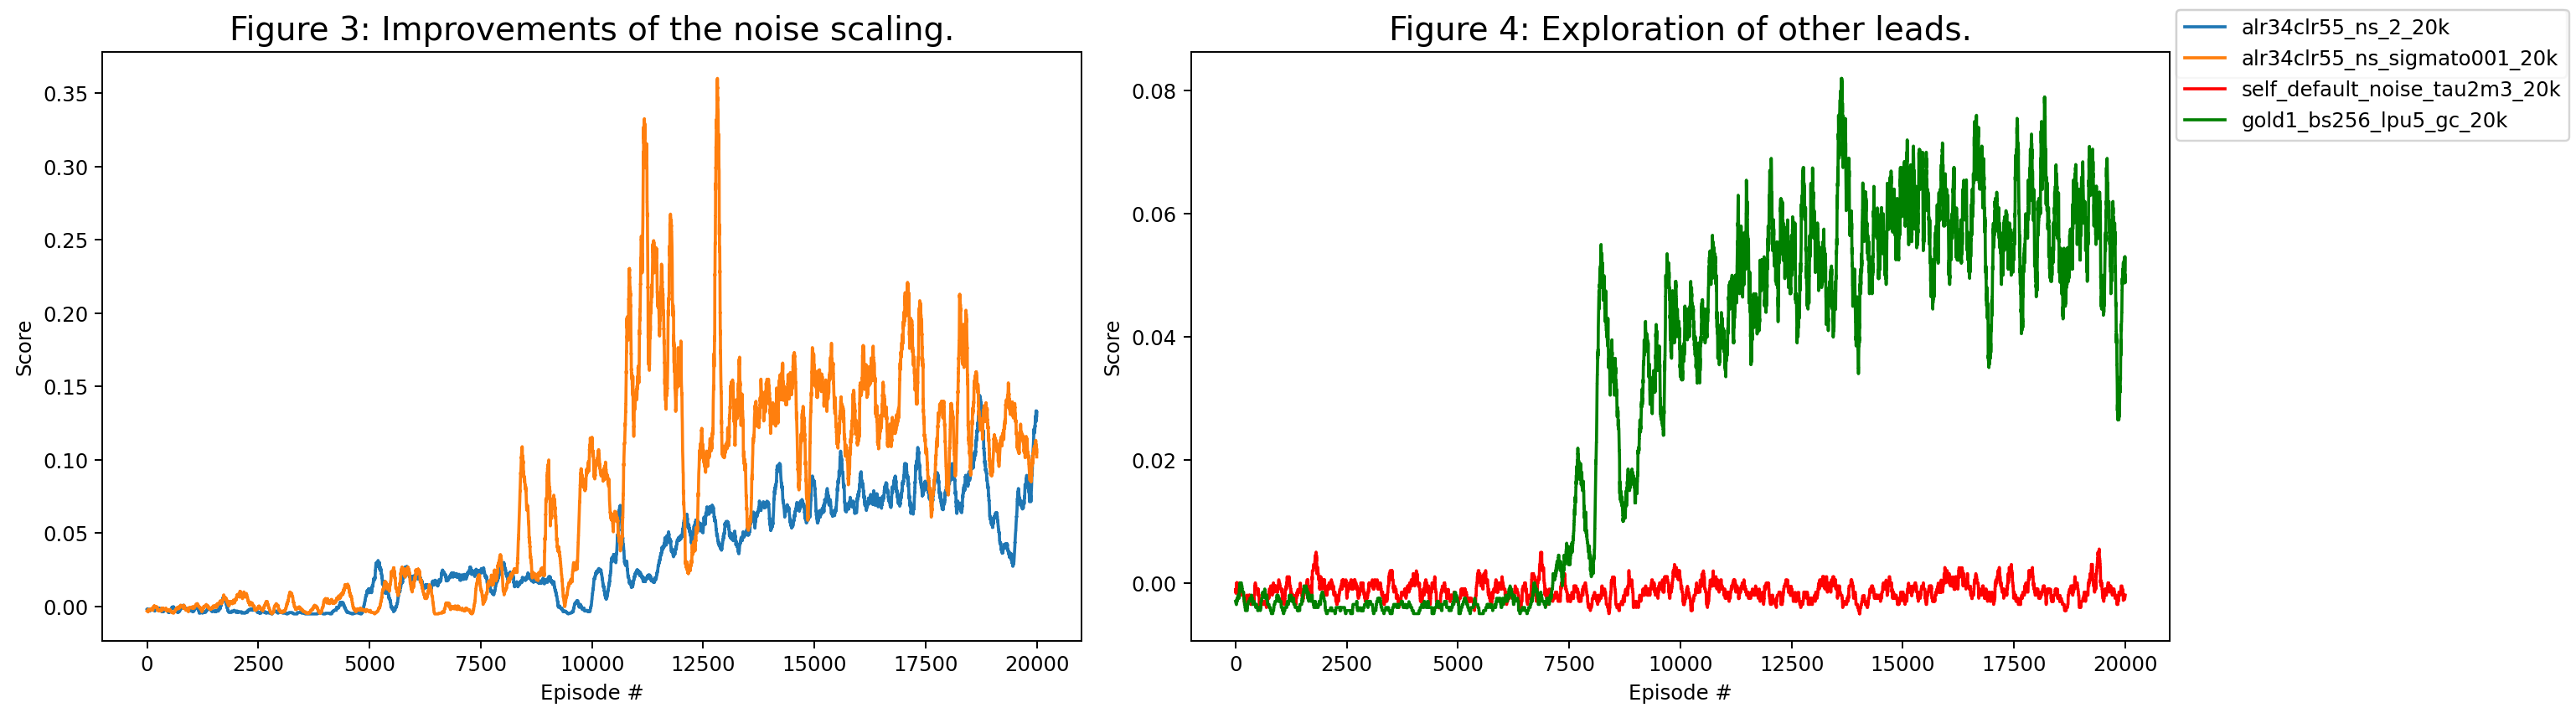

In [11]:
fig, axes = plt.subplots(1,2,figsize=(15,5), dpi=175)
axes = iter(axes)

plot_scores(load_scores(keys=['alr34clr55_ns_2_20k', 'alr34clr55_ns_sigmato001_20k']),
             window_size=100, axe=next(axes), title="Figure 3: Improvements of the noise scaling.")
plot_scores(load_scores(keys=['gold1_bs256_lpu5_gc_20k','self_default_noise_tau2m3_20k']),
            window_size=100, axe=next(axes), colors=['r','g'], title="Figure 4: Exploration of other leads.")

*Figure 3* present the next increase of performance which was reach thanks to the introduction of scaling in the noise. Like the adaptation of epsilon in epsilon-greedy policy, a high noise amplitude for the first interactions enable more exploration and lower value later allow more stable progress to take place.  
Many other avenues of development have been explored, *Figure 4*  display some results of those research. The green curve present the performances obtains by incorporating many tweaks such as the introduction of gradient clipping and explorations around the hyperparameters of the bach size and the number of updates by learing step.  
For the record, the red performance curve illustrate one of the many failed attempted of improvement where only one actor was used for both agent in an try to adapt the self-play concept to this environment. Among oher ideas and after observing trained agents ineracting with and without leaning step and noise, a stateful agent whose different state would have been triggered by performance threshold was also tested without any meaningful results.

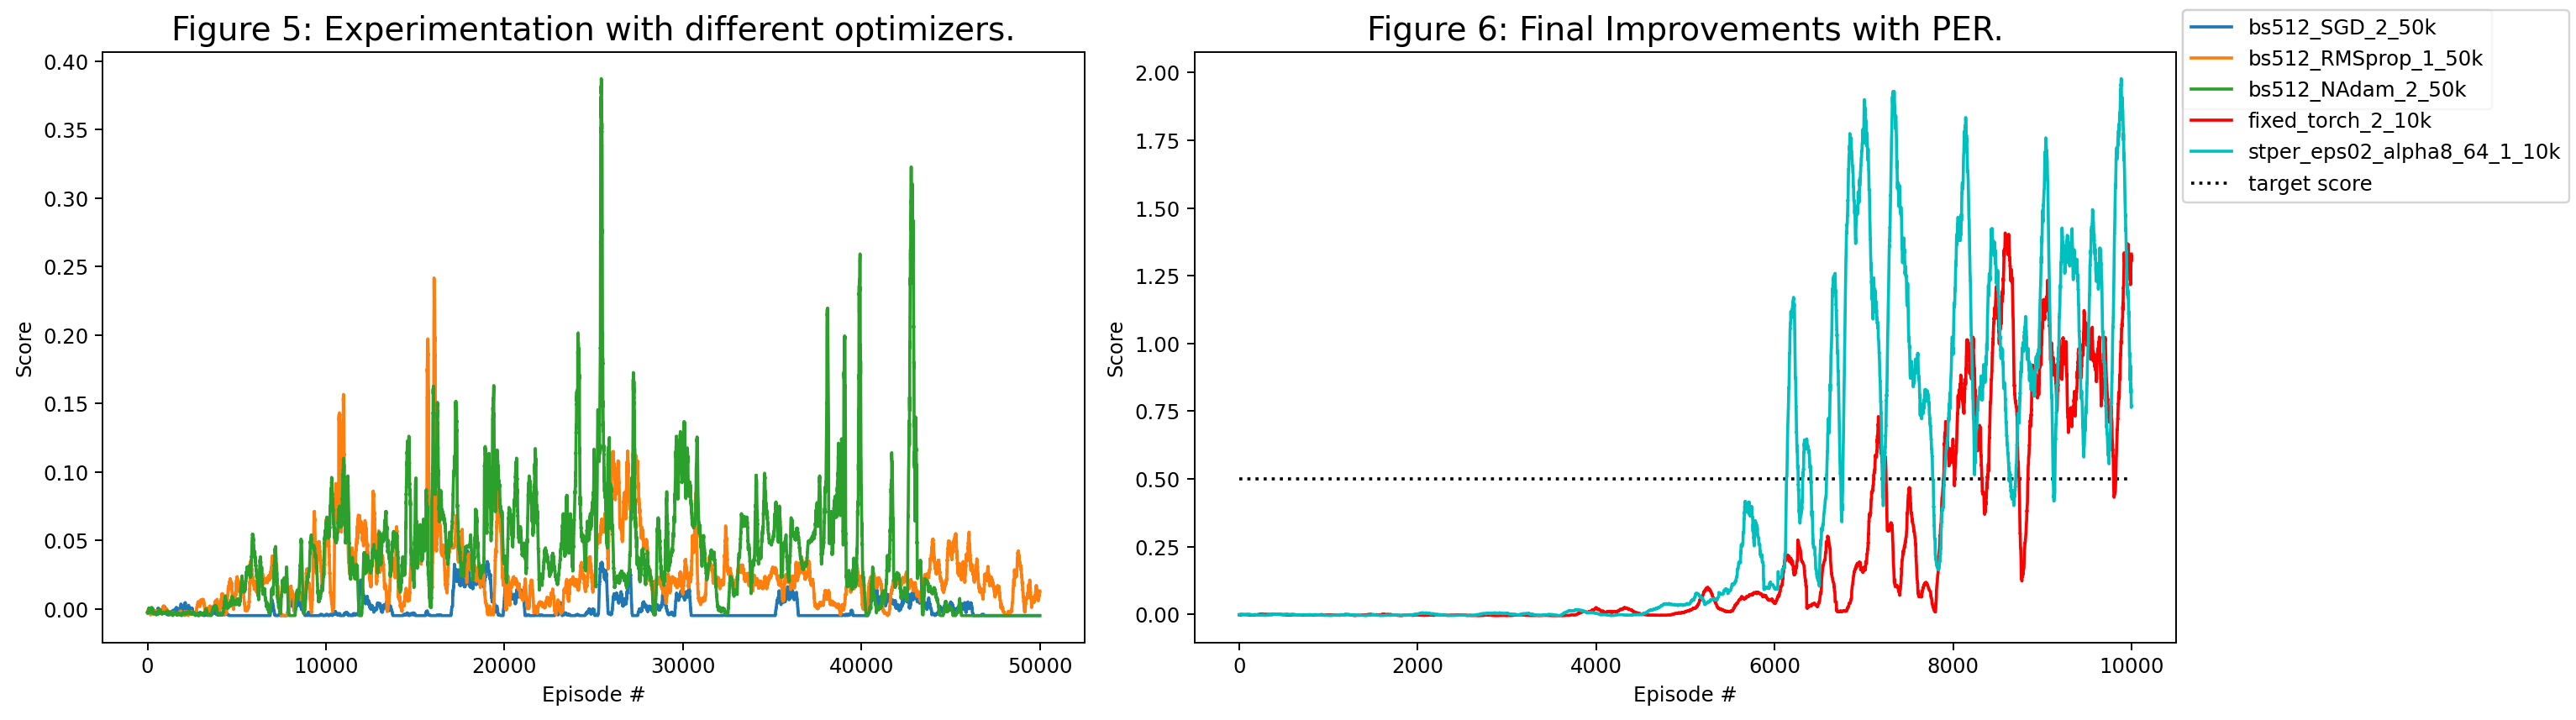

In [16]:
fig, axes = plt.subplots(1,2,figsize=(15,5), dpi=175)
axes = iter(axes)

plot_scores(load_scores(keys=['bs512_NAdam_2_50k', 'bs512_RMSprop_1_50k', 'bs512_SGD_2_50k']),
            window_size=100, axe=next(axes), title="Figure 5: Experimentation with different optimizers.")
plot_scores(load_scores(keys=['fixed_torch_2_10k', 'stper_eps02_alpha8_64_1_10k']),
            target_score=.5, window_size=100, axe=next(axes), colors=['r','c'], title="Figure 6: Final Improvements with PER.")

*Figure 5* show further experimentations with this times the optimizer of the critic. The idea was that the momentum used in Adam could make the optimisation of the network bounce from local optima wich would have been enough to reach the target score. Unfortunatly, no other optimizer show better result than Adam except Nadam wich was too slow.  
Final after some last adjustments of the learning hyperparameters the target score was reached as illustrated by the *Fiogure 6*. The introduction of a prioritized experience replay prove to fasten and greatly stabilize the learning which was steady enough to leave the performance of the agent above the target score once reached.

### Ideas for Future Work

- As mention in the paper [Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments](https://arxiv.org/abs/1706.02275), it is possible to "purify" the MARL approach of MADDPG by not sharing informations across agents even during learning by **inferring other agent policy**. Indeed, note that the critic update requires the policies of all the agents as well as their observations. This condition can be relaxed by learning other agent policies from observations only without significant loss of performance. Estaplishing that agents are able to successful approximate the other agent policies rather than relying directly on their actions would be a great result to demonstrate.  

- Take advantage of the MADDP architure to explorate even more the MARL setting by trying **different kind of rewards**. I expect that making a competitive agent face a collaborative one, or even two competitive agents would be rich in teachings about what can be done when designing a RL problem.

- The **hyperparameters tuning** is a very time-consuming process and large improvements must be possible by following this path. The lack of method made this search complicated and worrying. Improvements in the network architecture could also improve the performances. Playing further with the size of the hidden layers or with that activation functions (trying LearkyReLU for instance) are good place to start.

- The multi agent proximal policy optimisation, **MAPPO**, is potent option to solve multi agent environemnent. It can be interesting to attempt to stabilize engough the  variance induced by the multi-agent setting when used with a policy gradient method. The research paper [the Surprising Effectiveness of PPO in Cooperative, Multi-Agent Games](https://arxiv.org/abs/2103.01955) can be solid scientific base to apply to the tennis environment.


- At last, it would be a great test for this implementation to try to adapt it to **different environments** such as the soccer one.

#### Questions
As I work on the projet, I did stumble upon interrogations that did not yet found answer. I ask them there : 
- Why did the self-play implementation present in the repository did not manage to learn significant policies?
- Why does the critic network archicture used in the MADDPG [paper](https://arxiv.org/abs/1706.02275) is not the same as the usual critic architecture used for DDPG? In the feed forward of the classic DDPG, the state is inputed first, go throught a layer and then the output is concatenated to the action to finally compute the Q-values whereas the concatenation of the observations and the actions occur at the start of the feed forward in the MADDPG case. 
- I did not manage to record gif of interaction of the agent and the environment. Is there a way to save gif from that RL environment ?